# Data Loading and pre-processing

In [1]:
# import load libraries
import pandas as pd
import numpy as np

In [2]:
# Load the data from csv
path = r'C:/Users/taty_/OneDrive/Área de Trabalho/Doutorado/Escrita artigo ML/Códigos github/Database Raw.csv'

Perovskites = pd.read_csv(path, 
                          decimal = '.')

#Perovskites

In [3]:
# Remove data-tracking columns (identify the origin of the observations)
Perovskites = Perovskites.drop(['Articles', 
                                'DOI', 
                                'Diameter_from', 
                                'Bandgap_from'], 
                                axis=1)

#Perovskites

In [4]:
# Remove variables that will not be used on this study (cathegorical variables that we will not apply one-hot encoder)
Perovskites = Perovskites.drop(['Phosphine',
                                'Phosphine_amount_mmol',
                                'Amine','Carboxylic_acid',
                                'Solvent_I',
                                'Solvent_II'], 
                                axis=1)

#Perovskites

In [5]:
# Remove the perovskite especification (we want a compound-agnostic model)
Perovskites = Perovskites.drop(['Perovskite'], 
                               axis=1)

#Perovskites

In [6]:
# remove outliers
Perovskites = Perovskites.drop([37,52,154, 56, 15, 65], 
                               axis=0, 
                               inplace=False)
#Perovskites

# Feature Selection

### Pearson's Correlation

In [7]:
# import plot libraries
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score

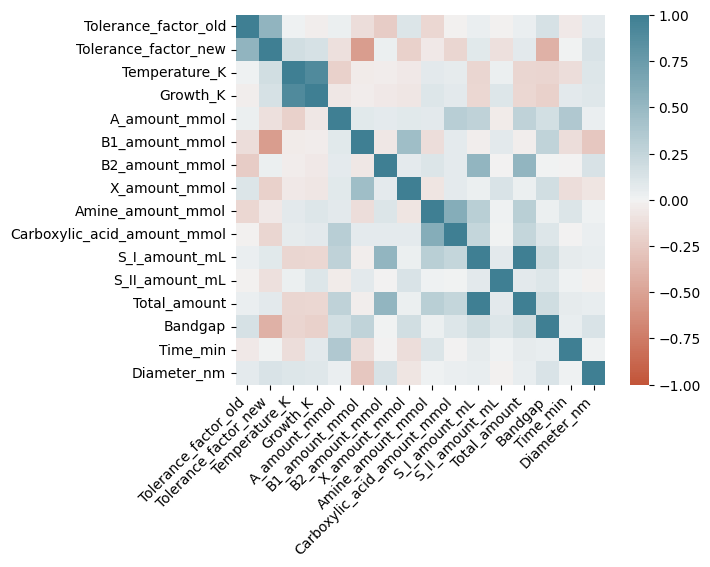

In [8]:
# Correlation plot shown in Support Information (FIGURE S1)
heatmap = sns.heatmap(Perovskites.select_dtypes(include=np.number).corr(), 
                      vmin=-1, 
                      vmax=1, 
                      annot=False, 
                      cmap=sns.diverging_palette(20, 220, n=200),
                      square=True)

heatmap.set_xticklabels(heatmap.get_xticklabels(),
                       rotation=45,
                       horizontalalignment='right')

plt.show()

In [9]:
# remove correlated variables (based on correlation plot available in the Support Information)
Perovskites = Perovskites.drop(['Total_amount',
                                'Tolerance_factor_old',
                                'Growth_K'], 
                               axis=1)

#Perovskites

### SHAP Variable Importance

In [10]:
# import random forest, metrics and shap libraries

from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn.preprocessing import OneHotEncoder
from hyperopt import hp, fmin, tpe, space_eval, Trials, atpe
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
import shap

In [11]:
# Selecting only numerical features for random forest training
x_shap = Perovskites[['Tolerance_factor_new', 
                      'Temperature_K', 
                      'B2_amount_mmol',\
                      'A_amount_mmol', 
                      'Carboxylic_acid_amount_mmol', \
                      'S_I_amount_mL', 
                      'S_II_amount_mL', 
                      'Diameter_nm']]

In [12]:
# Selecting the targets
y_shap = Perovskites[['B1_amount_mmol',  
                      'X_amount_mmol', 
                      'Time_min','Bandgap', 
                      'Amine_amount_mmol']]

In [13]:
# Applying logarithmic transformation for features with wide numerical range
x_shap['Diameter_nm'] = np.log10(x_shap["Diameter_nm"])
x_shap['B2_amount_mmol'] = np.log10(x_shap["B2_amount_mmol"])
x_shap['Temperature_K'] = np.log10(x_shap["Temperature_K"])
x_shap['Tolerance_factor_new'] = np.log10(x_shap["Tolerance_factor_new"])

y_shap['Time_min'] = np.log10(y_shap["Time_min"])
y_shap['Bandgap'] = np.log10(y_shap["Bandgap"])


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

In [14]:
# Train/Test set split (75% training and 25% test)
np.random.seed(100)

X_train_shap, X_test_shap, y_train_shap, y_test_shap = train_test_split(x_shap, y_shap, test_size=0.25, random_state=25) 

In [15]:
# hyperopt
# Define the search space
space = {
    'bootstrap': hp.choice('bootstrap', [True, False]),
    'max_depth': hp.choice('max_depth', range(1, 1000)),
    'max_features': hp.choice('max_features', [1.0, 'sqrt']),
    'min_samples_leaf': hp.choice('min_samples_leaf', range(2, 10)),
    'min_samples_split': hp.choice('min_samples_split', range(2, 10)),
    'n_estimators': hp.choice('n_estimators', range(100, 1000))
}


In [16]:
# Defining cross-validation settings
cv = KFold(n_splits=5, 
           random_state=25, 
           shuffle=True)

In [17]:
# Define the objective function
def objective(params):
    rf = RandomForestRegressor(**params)
    scores = cross_val_score(rf, X_train_shap, y_train_shap, cv=cv, scoring='neg_mean_squared_error')
    rmse = np.sqrt(-scores.mean())  # Negative mean squared error to minimize
    return rmse

In [18]:
# Run the hyperparameter optimization
trials = Trials()
best = fmin(fn=objective, 
            space=space, 
            algo=tpe.suggest, 
            max_evals=100, 
            trials=trials)

  0%|          | 0/100 [00:02<?, ?trial/s, best loss=?]


KeyboardInterrupt: 

In [ ]:
# Get the best hyperparameters
best_params = space_eval(space, best)
best_params

In [ ]:
# Train and evaluate a Random Forest regressor with the best hyperparameters
rf_feat_select = RandomForestRegressor(**best_params)
rf_feat_select.fit(X_train_shap, y_train_shap)
scores = cross_val_score(rf_feat_select, 
                         X_train_shap, 
                         y_train_shap, 
                         cv=cv, 
                         scoring='neg_root_mean_squared_error')
scores*(-1)

In [ ]:
# Prediction on train and test set
y_pred_feat_select = rf_feat_select.predict(X_test_shap)
y_pred_train_feat_select = rf_feat_select.predict(X_train_shap)

In [ ]:
# Training metrics 
MAE_train_feat_select = pd.DataFrame(mean_absolute_error(y_train_shap, y_pred_train_feat_select, multioutput='raw_values'))
RMSE_train_feat_select = pd.DataFrame(np.sqrt(mean_squared_error(y_train_shap, y_pred_train_feat_select, multioutput='raw_values')))
R2_train_feat_select = pd.DataFrame(r2_score(y_train_shap, y_pred_train_feat_select, multioutput='raw_values'))

train_metrics_feat_select = pd.concat([MAE_train_feat_select, RMSE_train_feat_select, R2_train_feat_select], axis='columns')
train_metrics_feat_select.columns = ['MAE_train_FS', 'RMSE_train_FS', 'R2_train_FS']

print(train_metrics_feat_select)

In [ ]:
# Test metrics
MAE_test_feat_select = pd.DataFrame(mean_absolute_error(y_test_shap, y_pred_feat_select, multioutput='raw_values'))
RMSE_test_feat_select = pd.DataFrame(np.sqrt(mean_squared_error(y_test_shap, y_pred_feat_select, multioutput='raw_values')))
R2_test_feat_select = pd.DataFrame(r2_score(y_test_shap, y_pred_feat_select, multioutput='raw_values'))

test_metrics_feat_select = pd.concat([MAE_test_feat_select, RMSE_test_feat_select, R2_test_feat_select], axis='columns')
test_metrics_feat_select.columns = ['MAE_test_FS', 'RMSE_test_FS', 'R2_test_FS']

print(test_metrics_feat_select)

In [ ]:
# Unite train and test performance dataframes (FIGURE S2-a)
df_unified_fs = pd.concat([train_metrics_feat_select, test_metrics_feat_select], axis=1)
df_unified_fs

In [ ]:
# shap plot para o modelo geral
explainer = shap.TreeExplainer(rf_feat_select, data = X_train_shap, link = "identity")
shap_values_rf = explainer.shap_values(X_train_shap, check_additivity=False)

In [ ]:
# Use index positions as feature names
feature_names = X_train_shap.columns.astype(str)

In [ ]:
# Sum up the SHAP values across all classes
shap_values_combined = np.sum(shap_values_rf, axis=0)

In [ ]:
# Create a single SHAP summary plot for all classes
shap.summary_plot(shap_values_combined, X_train_shap, feature_names=feature_names, show=False)

# Display the plot (FIGURE S2-a)
shap.initjs()
plt.show()

In [23]:
# feature removal based on shap feature importance
Perovskites = Perovskites.drop(['S_II_amount_mL'], axis=1)

In [ ]:
# Re-evaluation of feature importance after removal
# Selecting only numerical features for random forest training
x_shap = Perovskites[['Tolerance_factor_new', 'Temperature_K', 'B2_amount_mmol',\
                    'A_amount_mmol', 'Carboxylic_acid_amount_mmol', \
                    'S_I_amount_mL', 'Diameter_nm']]

In [ ]:
# Applying logarithmic transformation for features with wide numerical range
x_shap['Diameter_nm'] = np.log10(x_shap["Diameter_nm"])
x_shap['B2_amount_mmol'] = np.log10(x_shap["B2_amount_mmol"])
x_shap['Temperature_K'] = np.log10(x_shap["Temperature_K"])
x_shap['Tolerance_factor_new'] = np.log10(x_shap["Tolerance_factor_new"])

In [ ]:
# Train/Test set split (75% training and 25% test)
np.random.seed(100)
X_train_shap, X_test_shap, y_train_shap, y_test_shap = train_test_split(x_shap, y_shap, test_size=0.25, random_state=25)

In [ ]:
# hyperopt
# Define the search space
space = {
    'bootstrap': hp.choice('bootstrap', [True, False]),
    'max_depth': hp.choice('max_depth', range(1, 1000)),
    'max_features': hp.choice('max_features', [1.0, 'sqrt']),
    'min_samples_leaf': hp.choice('min_samples_leaf', range(2, 10)),
    'min_samples_split': hp.choice('min_samples_split', range(2, 10)),
    'n_estimators': hp.choice('n_estimators', range(100, 1000))
}

In [ ]:
# Defining cross-validation settings
cv = KFold(n_splits=5, random_state=25, shuffle=True)

In [ ]:
# Run the hyperparameter optimization
trials = Trials()
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=100, trials=trials)

In [ ]:
# Get the best hyperparameters
best_params = space_eval(space, best)
best_params

In [ ]:
# Train and evaluate a Random Forest regressor with the best hyperparameters
rf_feat_select = RandomForestRegressor(**best_params)
rf_feat_select.fit(X_train_shap, y_train_shap)
scores = cross_val_score(rf_feat_select, X_train_shap, y_train_shap, cv=cv, scoring='neg_root_mean_squared_error')
scores*(-1)

In [ ]:
## shap plot para o modelo geral
explainer = shap.TreeExplainer(rf_feat_select, data = X_train_shap, link = "identity")
shap_values_rf = explainer.shap_values(X_train_shap, check_additivity=False)

In [ ]:
# Use index positions as feature names
feature_names = X_train_shap.columns.astype(str)

In [ ]:
# Sum up the SHAP values across all classes
shap_values_combined = np.sum(shap_values_rf, axis=0)

In [ ]:
# Create a single SHAP summary plot for all classes
shap.summary_plot(shap_values_combined, X_train_shap, feature_names=feature_names, show=False)

# Display the plot (FIGURE S2-b)
shap.initjs()
plt.show()

# Feature Engineering

### One-hot encoding to categorical variables

In [24]:
# applying one hot encoding to categorical variables
Perovskites_encoded = pd.get_dummies(Perovskites, columns=['A_source','B1_source', 'B2_source', 'X_source'], dtype = int)
#print(Perovskites_encoded)

In [25]:
# applying logarithmic transformation to variables with high range 
Perovskites_encoded['Diameter_nm'] = np.log10(Perovskites_encoded['Diameter_nm'])
Perovskites_encoded['Time_min'] = np.log10(Perovskites_encoded['Time_min'])
Perovskites_encoded['B2_amount_mmol'] = np.log10(Perovskites_encoded['B2_amount_mmol'])
Perovskites_encoded['Temperature_K'] = np.log10(Perovskites_encoded['Temperature_K'])
Perovskites_encoded['Bandgap'] = np.log10(Perovskites_encoded['Bandgap'])
Perovskites_encoded['Tolerance_factor_new'] = np.log10(Perovskites_encoded['Tolerance_factor_new'])
#Perovskites_encoded

In [26]:
# Split data: predictors (x) and targets (y)
x = Perovskites_encoded.drop(['B1_amount_mmol', 'X_amount_mmol', 'Time_min', 'Bandgap', 'Amine_amount_mmol'],
                             axis=1)
y = Perovskites_encoded[[ 'B1_amount_mmol',  'X_amount_mmol', 'Time_min','Bandgap', 'Amine_amount_mmol']]

### Pre-processed data with selected features ready for training

In [27]:
# features (predictors) dataset
x

,Tolerance_factor_new,Temperature_K,A_amount_mmol,B2_amount_mmol,Carboxylic_acid_amount_mmol,S_I_amount_mL,Diameter_nm,A_source_cesium_acetate,A_source_cesium_bromide,A_source_cesium_carbonate,...,X_source_chlorotrimethylsilane,X_source_from_metal_salt,X_source_germanium_IV_chloride,X_source_indium_III_bromide,X_source_indium_III_chloride,X_source_indium_III_iodide,X_source_manganese_chloride,X_source_trimethylsilyl_iodide,X_source_zinc_bromide,X_source_zinc_iodide
0,0.612784,2.641474,0.65,-0.301030,9.19,10.00,1.357935,1,0,0,...,1,0,0,0,0,0,0,0,0,0
1,0.579784,2.646404,0.65,-0.301030,7.92,10.00,1.086360,1,0,0,...,1,0,0,0,0,0,0,0,0,0
2,0.578639,2.692847,0.16,-0.443697,3.68,14.64,1.357935,0,0,1,...,0,1,0,0,0,0,0,0,0,0
3,0.578639,2.615950,0.15,-0.522879,1.58,10.00,0.880814,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,0.584331,2.641474,0.65,-0.301030,8.87,10.00,1.096910,1,0,0,...,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
158,0.591065,2.626340,0.03,-0.886057,1.71,5.36,1.255273,0,0,1,...,0,1,0,0,0,0,0,0,0,0
159,0.605305,2.646404,0.40,0.397940,1.27,12.00,0.924279,0,0,1,...,0,1,0,0,0,0,0,0,0,0
160,0.627366,2.710117,0.05,-0.251812,6.56,8.73,1.017868,0,0,1,...,0,0,0,0,0,0,0,0,0,0
161,0.605305,2.710117,0.05,-0.251812,6.56,8.73,1.042969,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [28]:
# targets dataset
y

,B1_amount_mmol,X_amount_mmol,Time_min,Bandgap,Amine_amount_mmol
0,0.22,3.15,-1.698970,0.220108,1.98
1,0.45,3.15,-1.698970,0.491362,2.00
2,0.36,0.00,0.698970,0.556303,3.04
3,0.30,2.54,-1.096910,0.357935,0.73
4,0.45,3.15,-1.698970,0.658011,2.13
...,...,...,...,...,...
158,0.00,0.00,-1.096910,0.447158,1.52
159,0.00,0.00,0.000000,0.267172,1.22
160,0.00,1.12,-0.769551,0.089905,6.08
161,0.00,1.12,-0.769551,0.257679,6.08


In [29]:
# Train/Test split (75% training and 25% test)
np.random.seed(100)
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=25) 

# Training the models

## Decision Trees

### Hyperparameter optimization

In [30]:
# import decision tree library
from sklearn.tree import DecisionTreeRegressor

#### Hyperopt

In [31]:
# Define the search space
space = {
    'max_depth': hp.choice('max_depth', range(1, 1000)),
    'max_features': hp.choice('max_features', [1.0, 'sqrt']),
    'max_leaf_nodes': hp.choice('max_leaf_nodes', range(2, 500)),
    'min_samples_leaf': hp.choice('min_samples_leaf', range(2, 10)),
    'min_samples_split': hp.choice('min_samples_split', range(2, 10)),
    'min_weight_fraction_leaf': hp.choice('min_weight_fraction_leaf', [0.1])
}

In [32]:
# Defining cross-validation parameters
cv = KFold(n_splits=5, random_state=25, shuffle=True)

In [33]:
# Define the objective function
def objective(params):
    dt_ho = DecisionTreeRegressor(**params)
    scores = cross_val_score(dt_ho, X_train, y_train, cv=cv, scoring='neg_mean_squared_error')
    rmse = np.sqrt(-scores.mean())  # Negative mean squared error to minimize
    return rmse

In [34]:
# Run the hyperparameter optimization
trials = Trials()
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=100, trials=trials)

100%|██████████| 100/100 [00:18<00:00,  5.36trial/s, best loss: 2.0844200608800945]


In [35]:
# Get the best hyperparameters
best_params_ho = space_eval(space, best)
best_params_ho

{'max_depth': 424,
 'max_features': 'sqrt',
 'max_leaf_nodes': 414,
 'min_samples_leaf': 8,
 'min_samples_split': 9,
 'min_weight_fraction_leaf': 0.1}

#### Grid Search

In [36]:
# Specify the grid
param_grid = {
                   'max_depth': range(2,500,50),
                   'max_features': ('auto', 'sqrt'),
                   'max_leaf_nodes': range(2,500,50),
                   'min_samples_leaf': range(2,10),
                   'min_weight_fraction_leaf': [0.1],
                   'min_samples_split': range(2,10)
}

In [37]:
# Create a based model
dt_gs = DecisionTreeRegressor()

In [38]:
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = dt_gs, param_grid = param_grid, 
                          cv = 5, n_jobs = -1, verbose = 2)

In [39]:
# Fit the grid search to the data
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 12800 candidates, totalling 64000 fits


GridSearchCV(cv=5, estimator=DecisionTreeRegressor(), n_jobs=-1,
             param_grid={'max_depth': range(2, 500, 50),
                         'max_features': ('auto', 'sqrt'),
                         'max_leaf_nodes': range(2, 500, 50),
                         'min_samples_leaf': range(2, 10),
                         'min_samples_split': range(2, 10),
                         'min_weight_fraction_leaf': [0.1]},
             verbose=2)

In [40]:
# prediction on train and test set
y_pred = grid_search.best_estimator_.predict(X_test)
y_pred_train = grid_search.best_estimator_.predict(X_train)

In [41]:
print(grid_search.best_params_)

{'max_depth': 52, 'max_features': 'sqrt', 'max_leaf_nodes': 52, 'min_samples_leaf': 6, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.1}


#### Model Training and Evaluation (Hyperopt)

In [42]:
# Create a Decision Tree regressor with the best hyperparameters
dt_ho = DecisionTreeRegressor(**best_params_ho)

In [43]:
# Evaluating the cross-validation scores
scores = cross_val_score(dt_ho, X_train, y_train, cv=cv, scoring='neg_mean_squared_error')
scores*(-1)

array([11.66214175,  8.51610281,  3.05481038,  1.5951349 ,  2.15379454])

In [44]:
# Training the Decision Tree regressor
dt_ho.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=424, max_features='sqrt', max_leaf_nodes=414,
                      min_samples_leaf=8, min_samples_split=9,
                      min_weight_fraction_leaf=0.1)

In [45]:
# Prediction on test set
y_pred_ho = dt_ho.predict(X_test)
#y_pred

In [46]:
# Prediction on train set
y_pred_train_ho = dt_ho.predict(X_train)

In [47]:
# Performance metrics on train dataset
MAE_train = pd.DataFrame(metrics.mean_absolute_error(y_train, y_pred_train_ho, multioutput='raw_values'))
RMSE_train = pd.DataFrame(np.sqrt(metrics.mean_squared_error(y_train, y_pred_train_ho, multioutput='raw_values')))
R2_train = pd.DataFrame(r2_score(y_train, y_pred_train_ho, multioutput='raw_values'))

train_metrics_dt = pd.concat([MAE_train, RMSE_train, R2_train], axis='columns')
train_metrics_dt.columns = ['MAE_train_HO','RMSE_train_HO','R2_train_HO']
print(train_metrics_dt)

   MAE_train_HO  RMSE_train_HO  R2_train_HO
0      0.058717       0.094437     0.723965
1      1.177688       2.206045     0.309075
2      0.546575       0.703982     0.195895
3      0.119298       0.144605     0.159528
4      1.738614       3.936346     0.220341


In [48]:
# Performance metrics on test dataset
MAE_test_dt = pd.DataFrame(metrics.mean_absolute_error(y_test, y_pred_ho, multioutput='raw_values'))
RMSE_test_dt = pd.DataFrame(np.sqrt(metrics.mean_squared_error(y_test, y_pred_ho, multioutput='raw_values')))
R2_test_dt =pd.DataFrame(r2_score(y_test, y_pred_ho, multioutput='raw_values'))

test_metrics_dt = pd.concat([MAE_test_dt, RMSE_test_dt, R2_test_dt], axis='columns')
test_metrics_dt.columns = ['MAE_test_HO', 'RMSE_test_HO','R2_test_HO']
print(test_metrics_dt)

   MAE_test_HO  RMSE_test_HO  R2_test_HO
0     0.040084      0.067035    0.857069
1     1.226262      1.832314    0.202413
2     0.568555      0.663700    0.224838
3     0.114500      0.134550    0.081934
4     2.864718      5.995642    0.082131


In [ ]:
# Unite train and test performance dataframes 
df_unified_ho = pd.concat([train_metrics_dt, test_metrics_dt], axis=1)
df_unified_ho

#### Model Training and Evaluation (Grid Search)

In [49]:
# Evaluating the cross-validation scores
scores = cross_val_score(grid_search.best_estimator_, X_train, y_train, cv=cv, scoring='neg_mean_squared_error')
scores*(-1)

array([13.05986342,  7.9249271 ,  2.79397064,  0.8532405 ,  2.79731064])

In [50]:
# Training the Decision Tree regressor
grid_search.best_estimator_.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=52, max_features='sqrt', max_leaf_nodes=52,
                      min_samples_leaf=6, min_weight_fraction_leaf=0.1)

In [51]:
# Prediction on test set
y_pred = grid_search.best_estimator_.predict(X_test)
#y_pred

In [52]:
# Prediction on train set
y_pred_train = grid_search.best_estimator_.predict(X_train)

In [53]:
# Performance metrics on train dataset
MAE_train = pd.DataFrame(metrics.mean_absolute_error(y_train, y_pred_train, multioutput='raw_values'))
RMSE_train = pd.DataFrame(np.sqrt(metrics.mean_squared_error(y_train, y_pred_train, multioutput='raw_values')))
R2_train = pd.DataFrame(r2_score(y_train, y_pred_train, multioutput='raw_values'))

train_metrics_dt = pd.concat([MAE_train, RMSE_train, R2_train], axis='columns')
train_metrics_dt.columns = ['MAE_train_GS','RMSE_train_GS','R2_train_GS']
print(train_metrics_dt)

   MAE_train_GS  RMSE_train_GS  R2_train_GS
0      0.114420       0.150740     0.296702
1      0.910572       2.101394     0.373073
2      0.533269       0.698184     0.209087
3      0.113257       0.141473     0.195540
4      1.808555       3.843545     0.256669


In [54]:
# Performance metrics on test dataset
MAE_test_dt = pd.DataFrame(metrics.mean_absolute_error(y_test, y_pred, multioutput='raw_values'))
RMSE_test_dt = pd.DataFrame(np.sqrt(metrics.mean_squared_error(y_test, y_pred, multioutput='raw_values')))
R2_test_dt = pd.DataFrame(r2_score(y_test, y_pred, multioutput='raw_values'))

test_metrics_dt = pd.concat([MAE_test_dt, RMSE_test_dt, R2_test_dt], axis='columns')
test_metrics_dt.columns = ['MAE_test_GS', 'RMSE_test_GS','R2_test_GS']
print(test_metrics_dt)

   MAE_test_GS  RMSE_test_GS  R2_test_GS
0     0.120732      0.150846    0.276249
1     0.784220      1.390845    0.540447
2     0.519492      0.687530    0.168176
3     0.108311      0.128024    0.168832
4     2.480294      5.251732    0.295770


In [ ]:
# Unite train and test performance dataframes 
df_unified_gs = pd.concat([train_metrics_dt, test_metrics_dt], axis=1)
#df_unified_gs

In [ ]:
# Unite performance dataframes from hyperopt and grid search (TABLE S4 - Decision Trees)
df_unified_dt = pd.concat([df_unified_ho, df_unified_gs], axis=1)
df_unified_dt

#### Performance Evaluation

In [ ]:
# List to store multiple figure and figure names
file_names = []
figs = []

In [ ]:
# Defining color palette
colors = sns.diverging_palette(20, 220, n=200)
cor_teste = 20
cor_treino = 190

In [ ]:
# Defining number of columns
num_cols = y_train.shape[1]

In [ ]:
# Loop to plot parity plot for all targets (FIGURE 4 - Decision Trees)
for i in range(num_cols):
    # Create figure and axis
    fig, ax = plt.subplots(figsize=(6, 4))
    
    target = y_train.columns[i]
    
    # Scatter plot for predictions on test data
    ax.scatter(y_test.iloc[:, i], y_pred_ho[:, i], color=colors[cor_teste], label='Test Set', s=30)
    
    # Scatter plot for predictions on training data
    ax.scatter(y_train.iloc[:, i], y_pred_train_ho[:, i], color=colors[cor_treino], label='Train Set', s=30)
    
    # Diagonal reference line
    ax.plot([min(y_test.iloc[:, i].values), max(y_test.iloc[:, i].values)],
            [min(y_test.iloc[:, i].values), max(y_test.iloc[:, i].values)],
            color='black', linestyle='--')
    
    # Calculating validation metrics
    r2 = r2_score(y_test.iloc[:, i], y_pred_ho[:, i])
    mae = mean_absolute_error(y_test.iloc[:, i], y_pred_ho[:, i])
    rmse = np.sqrt(mean_squared_error(y_test.iloc[:, i], y_pred_ho[:, i]))
    
    # Add validation metrics to the plot
    ax.text(0.04, 0.65, f'R²: {r2:.2f}\nMAE: {mae:.2f}\nRMSE: {rmse:.2f}', transform=ax.transAxes, fontsize=18)
    
    # Defining y axis label
    ax.set_ylabel('Predicted values', fontsize=22)
        
    # Defining x axis label
    ax.set_xlabel('True Values', fontsize=22)

    # Changing axis character size
    ax.tick_params(axis='both', which='major', labelsize=16)
        
    # Name of the target
    ax.set_title(f'{target}', fontsize=20, fontweight='bold')
    
    # Positioning legend outside the plot
    fig.legend(loc='center left', bbox_to_anchor=(0.95, 0.5),frameon=False, fontsize=14)
    
    # Resolution adjust
    fig.set_dpi(500)

    # Add figure to list
    figs.append(fig)
    
    # Show the plot
    plt.tight_layout()
    plt.show()

In [ ]:
# shap plot for general model (combined targets)
explainer = shap.TreeExplainer(dt_ho, data = X_train, link = "identity")
shap_values_dt = explainer.shap_values(X_train, check_additivity=False)

In [ ]:
# Use index positions as feature names
feature_names = X_train.columns.astype(str)

In [ ]:
# Sum up the SHAP values across all classes
shap_values_combined = np.sum(shap_values_dt, axis=0)

In [ ]:
# Create a single SHAP summary plot for all classes
shap.summary_plot(shap_values_combined, X_train, feature_names=feature_names, show=False)

# Display the plot (FIGURE 6-a)
shap.initjs()
plt.show()

In [ ]:
# SHAP variable importance per feature x per target
class_names = y.columns
shap.summary_plot(shap_values_dt, X_train, class_names=class_names, max_display=10, show=False)

# Display the plot (FIGURE 6-a)
shap.initjs()
plt.show()

## Random Forest

### Hyperparameter optimization

#### Hyperopt

In [55]:
# Define the search space
space = {
    'bootstrap': hp.choice('bootstrap', [True, False]),
    'max_depth': hp.choice('max_depth', range(1, 1000)),
    'max_features': hp.choice('max_features', [1.0, 'sqrt', 'log2']),
    'min_samples_leaf': hp.choice('min_samples_leaf', range(2, 10)),
    'min_samples_split': hp.choice('min_samples_split', range(2, 10)),
    'n_estimators': hp.choice('n_estimators', range(100, 1000))
}

In [56]:
# Defining cross-validation parameters
cv = KFold(n_splits = 10, random_state = 25, shuffle = True)

In [57]:
# Define the objective function
def objective(params):
    rf = RandomForestRegressor(**params)
    scores = cross_val_score(rf, X_train, y_train, cv=cv, scoring='neg_mean_squared_error')
    rmse = np.sqrt(-scores.mean())  # Negative mean squared error to minimize
    return rmse

In [58]:
# Run the hyperparameter optimization
trials = Trials()
best = fmin(fn = objective, space = space, algo = tpe.suggest, max_evals = 200, trials = trials)

  0%|          | 1/200 [00:12<42:50, 12.91s/trial, best loss: 2.0846026765797476]


KeyboardInterrupt: 

In [ ]:
# Get the best hyperparameters
best_params = space_eval(space, best)
best_params

#### Grid Search

In [ ]:
# testing ranges for hyperparameters
param_grid = {
    'bootstrap': [True],
    'max_depth': range(10,500,50),
    'max_features': ['sqrt'],
    'min_samples_leaf': range(1,31,5),
    'min_samples_split': range(1,21,5),
    'n_estimators': range(100,500,50)
}

In [ ]:
# Create a based model
rf = RandomForestRegressor()

In [ ]:
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 5, n_jobs = -1, verbose = 2)

In [ ]:
# Fit the grid search to the data
grid_search.fit(X_train, y_train)

In [ ]:
print(grid_search.best_params_)

#### Model Training and Evaluation (hyperopt)

In [ ]:
# Create a Random Forest regressor with the best hyperparameters - hyperopt
rf = RandomForestRegressor(random_state=123, **best_params)

In [ ]:
# Evaluating the cross-validation scores
scores = cross_val_score(rf, X_train, y_train, cv=cv, scoring='neg_mean_squared_error')
scores*(-1)

In [ ]:
# Training the Random Forest regressor
rf.fit(X_train, y_train)

In [ ]:
# Prediction on train and test set
y_pred_ho = rf.predict(X_test)
y_pred_train_ho = rf.predict(X_train)

In [ ]:
# Training metrics
MAE_train_rf = pd.DataFrame(mean_absolute_error(y_train, y_pred_train_ho, multioutput='raw_values'))
RMSE_train_rf = pd.DataFrame(np.sqrt(mean_squared_error(y_train, y_pred_train_ho, multioutput='raw_values')))
R2_train_rf = pd.DataFrame(r2_score(y_train, y_pred_train_ho, multioutput='raw_values'))

train_metrics_rf = pd.concat([MAE_train_rf, RMSE_train_rf, R2_train_rf], axis='columns')
train_metrics_rf.columns = ['MAE_train_HO', 'RMSE_train_HO', 'R2_train_HO']

print(train_metrics_rf)

In [ ]:
# Test metrics
MAE_test_rf = pd.DataFrame(mean_absolute_error(y_test, y_pred_ho, multioutput='raw_values'))
RMSE_test_rf = pd.DataFrame(np.sqrt(mean_squared_error(y_test, y_pred_ho, multioutput='raw_values')))
R2_test_rf = pd.DataFrame(r2_score(y_test, y_pred_ho, multioutput='raw_values'))

test_metrics_rf = pd.concat([MAE_test_rf, RMSE_test_rf, R2_test_rf], axis='columns')
test_metrics_rf.columns = ['MAE_test_HO', 'RMSE_test_HO', 'R2_test_HO']

print(test_metrics_rf)

In [ ]:
# Unite train and test performance dataframes 
df_unified_ho = pd.concat([train_metrics_rf, test_metrics_rf], axis=1)
df_unified_ho

#### Performance evaluation (hyperopt): Parity Plots

In [ ]:
# List to store multiple figure and figure names
file_names = []
figs = []

In [ ]:
# Defining color palette
colors = sns.diverging_palette(20, 220, n=200)
cor_teste = 20
cor_treino = 190

In [ ]:
# Defining number of columns
num_cols = y_train.shape[1]

In [ ]:
# Loop to plot parity plot for all targets (FIGURE 4 - Decision Trees)
for i in range(num_cols):
    # Create figure and axis
    fig, ax = plt.subplots(figsize=(6, 4))
    
    target = y_train.columns[i]
    
    # Scatter plot for predictions on test data
    ax.scatter(y_test.iloc[:, i], y_pred_ho[:, i], color=colors[cor_teste], label='Test Set', s=30)
    
    # Scatter plot for predictions on training data
    ax.scatter(y_train.iloc[:, i], y_pred_train_ho[:, i], color=colors[cor_treino], label='Train Set', s=30)
    
    # Diagonal reference line
    ax.plot([min(y_test.iloc[:, i].values), max(y_test.iloc[:, i].values)],
            [min(y_test.iloc[:, i].values), max(y_test.iloc[:, i].values)],
            color='black', linestyle='--')
    
    # Calculating validation metrics
    r2 = r2_score(y_test.iloc[:, i], y_pred_ho[:, i])
    mae = mean_absolute_error(y_test.iloc[:, i], y_pred_ho[:, i])
    rmse = np.sqrt(mean_squared_error(y_test.iloc[:, i], y_pred_ho[:, i]))
    
    # Add validation metrics to the plot
    ax.text(0.04, 0.65, f'R²: {r2:.2f}\nMAE: {mae:.2f}\nRMSE: {rmse:.2f}', transform=ax.transAxes, fontsize=18)
    
    # Defining y axis label
    ax.set_ylabel('Predicted values', fontsize=22)
        
    # Defining x axis label
    ax.set_xlabel('True Values', fontsize=22)

    # Changing axis character size
    ax.tick_params(axis='both', which='major', labelsize=16)
        
    # Name of the target
    ax.set_title(f'{target}', fontsize=20, fontweight='bold')
    
    # Positioning legend outside the plot
    fig.legend(loc='center left', bbox_to_anchor=(0.95, 0.5),frameon=False, fontsize=18)
    
    # Resolution adjust
    fig.set_dpi(500)

    # Add figure to list
    figs.append(fig)
    
    # Show the plot
    plt.tight_layout()
    plt.show()

#### Model Training and Evaluation (Grid Search)

In [ ]:
# Evaluating the cross-validation scores
scores = cross_val_score(grid_search.best_estimator_, X_train, y_train, cv=cv, scoring='neg_mean_squared_error')
scores*(-1)

In [ ]:
# Training the Decision Tree regressor
grid_search.best_estimator_.fit(X_train, y_train)

In [ ]:
# Prediction on test set
y_pred = grid_search.best_estimator_.predict(X_test)
#y_pred

In [ ]:
# Prediction on train set
y_pred_train = grid_search.best_estimator_.predict(X_train)

In [ ]:
# Performance metrics on train dataset
MAE_train = pd.DataFrame(metrics.mean_absolute_error(y_train, y_pred_train, multioutput='raw_values'))
RMSE_train = pd.DataFrame(np.sqrt(metrics.mean_squared_error(y_train, y_pred_train, multioutput='raw_values')))
R2_train = pd.DataFrame(r2_score(y_train, y_pred_train, multioutput='raw_values'))

train_metrics_rf = pd.concat([MAE_train, RMSE_train, R2_train], axis='columns')
train_metrics_rf.columns = ['MAE_train_GS','RMSE_train_GS','R2_train_GS']
print(train_metrics_rf)

In [ ]:
# Performance metrics on test dataset
MAE_test_rf = pd.DataFrame(metrics.mean_absolute_error(y_test, y_pred, multioutput='raw_values'))
RMSE_test_rf = pd.DataFrame(np.sqrt(metrics.mean_squared_error(y_test, y_pred, multioutput='raw_values')))
R2_test_rf = pd.DataFrame(r2_score(y_test, y_pred, multioutput='raw_values'))

test_metrics_rf = pd.concat([MAE_test_rf, RMSE_test_rf, R2_test_rf], axis='columns')
test_metrics_rf.columns = ['MAE_test_GS', 'RMSE_test_GS','R2_test_GS']
print(test_metrics_rf)

In [ ]:
# Unite train and test performance dataframes 
df_unified_gs = pd.concat([train_metrics_rf, test_metrics_rf], axis=1)
df_unified_gs

In [ ]:
# Unite performance dataframes from hyperopt and grid search (Table 1)
df_unified_rf = pd.concat([df_unified_ho, df_unified_gs], axis=1)
df_unified_rf

#### Feature importance: SHAP

In [ ]:
e_rf2 = shap.TreeExplainer(model = rf, data = X_train, link = 'identity')
shap_values_rf2 = e_rf2.shap_values(X_train)

In [ ]:
class_names = y.columns

In [ ]:
# Use index positions as feature names
feature_names = X_train.columns.astype(str)

In [ ]:
# Sum up the SHAP values across all classes
shap_values_combined = np.sum(shap_values_rf2, axis=0)

In [ ]:
# Create a single SHAP summary plot for all classes
shap.summary_plot(shap_values_combined, X_train, max_display=10, feature_names=feature_names, show=False)

# Display the plot (FIGURE 6-b)
shap.initjs()
plt.show()

In [ ]:
# plot bar plot shap - per feature x per target
import ipywidgets as widgets

In [ ]:
e_rf = shap.TreeExplainer(rf)
shap_values_rf = e_rf.shap_values(X_train)

In [ ]:
# SHAP variable importance per feature x per target
class_names = y.columns
shap.summary_plot(shap_values_rf, X_train, class_names=class_names, max_display=10, show=False)

# Display the plot (FIGURE 6-b)
shap.initjs()
plt.show()

In [ ]:
# SHAP plot separated for each target (Figure S3)

e_rf = shap.TreeExplainer(rf)
shap_values_rf = e_rf.shap_values(X_train)

for i, shap_values_target in enumerate(shap_values_rf):
    target_name = class_names[i]
    shap.summary_plot(shap_values_target, X_train, max_display=10, show=False)
                      
    # Display the plot for the current target
    shap.initjs()
    plt.show()

#### Performance evaluation: Residual Plots

In [ ]:
# Defining color palette
colors = sns.diverging_palette(20, 220, n=200)
cor_pontos = 20
cor_reta = 190

In [ ]:
# Residual calculation and convertion to dataframe
y_pred_rf_ho = pd.DataFrame(y_pred_ho, columns=y_test.columns)
y_pred_rf_gs = pd.DataFrame(y_pred, columns=y_test.columns)

In [ ]:
# Redefining y_pred indexes
y_pred_rf_ho.reset_index(drop=True, inplace=True)
y_pred_rf_gs.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

In [ ]:
# List to store multiple figure and figure names
file_names = []
figs = []

In [ ]:
# Check if test and pred dataframes are the same size (FIGURE 7/FIGURE S4-b)
if len(y_test) == len(y_pred_rf_ho):
    # Residual calculation
    residuals = y_test - y_pred_rf_ho
    
    # Loop to plot residual plot for all targets
    for column in residuals.columns:
        # Create figure and axis
        fig, ax = plt.subplots()

        # get residual values as lists (iterable)
        predicted_values = y_pred_rf_ho[column].values.tolist()
        residual_values = residuals[column].values.tolist()

        # Residual Plot
        ax.scatter(predicted_values, residual_values, color=colors[cor_pontos], s=50)
        ax.axhline(y=0, color=colors[cor_reta], linestyle='-', linewidth=3)
        ax.set_xlabel('Predicted Values', fontsize=22)
        ax.set_ylabel('Residuals', fontsize=22)
        ax.set_title(column, fontsize=22)

        # Resolution adjust
        fig.set_dpi(500)

        # Residuals Statistics
        residual_mae = mean_absolute_error(y_test[column], y_pred_rf_ho[column])
        residual_rmse = np.sqrt(mean_squared_error(y_test[column], y_pred_rf_ho[column]))
        residual_r2 = r2_score(y_test[column], y_pred_rf_ho[column])

        # Add validation metrics to the plot
        text = f"MAE: {residual_mae:.4f}\nRMSE: {residual_rmse:.4f}\nR2 Score: {residual_r2:.4f}"
        ax.text(0.05, 0.95, text, transform=ax.transAxes, fontsize=16, verticalalignment='top')

        # Add figure to list
        figs.append(fig)
        
        # Show the plot
        plt.show()

In [ ]:
# Check if test and pred dataframes are the same size (FIGURE S4-a)
if len(y_test) == len(y_pred_rf_gs):
    # Residual calculation
    residuals = y_test - y_pred_rf_gs
    
    # Loop to plot residual plot for all targets
    for column in residuals.columns:
        # Create figure and axis
        fig, ax = plt.subplots()

        # get residual values as lists (iterable)
        predicted_values = y_pred_rf_gs[column].values.tolist()
        residual_values = residuals[column].values.tolist()

        # Residual Plot
        ax.scatter(predicted_values, residual_values, color=colors[cor_pontos], s=50)
        ax.axhline(y=0, color=colors[cor_reta], linestyle='-', linewidth=3)
        ax.set_xlabel('Predicted Values', fontsize=22)
        ax.set_ylabel('Residuals', fontsize=22)
        ax.set_title(column, fontsize=22)

        # Resolution adjust
        fig.set_dpi(500)

        # Residuals Statistics
        residual_mae = mean_absolute_error(y_test[column], y_pred_rf_gs[column])
        residual_rmse = np.sqrt(mean_squared_error(y_test[column], y_pred_rf_gs[column]))
        residual_r2 = r2_score(y_test[column], y_pred_rf_gs[column])

        # Add validation metrics to the plot
        text = f"MAE: {residual_mae:.4f}\nRMSE: {residual_rmse:.4f}\nR2 Score: {residual_r2:.4f}"
        ax.text(0.05, 0.95, text, transform=ax.transAxes, fontsize=16, verticalalignment='top')

        # Add figure to list
        figs.append(fig)
        
        # Show the plot
        plt.show()

### Neural Networks

In [ ]:
# import neural networks libraries
from sklearn.neural_network import MLPRegressor
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from sklearn.preprocessing import MinMaxScaler
import random as python_random
from scikeras.wrappers import KerasRegressor

In [ ]:
# Seed value
def reset_seeds():
   np.random.seed(9) 
   python_random.seed(9)
   tf.random.set_seed(9)

In [ ]:
# Feature scaling for neural network training
scaler = MinMaxScaler()
X_train_norm = scaler.fit_transform(X_train)
X_test_norm = scaler.fit_transform(X_test)

In [ ]:
# Reset seed value
reset_seeds() 

Hyperparameter Optimization - Using One-Hot Encoder

In [ ]:
# Model building
def create_model(units1, units2, units3):
    model = Sequential()
    model.add(Dense(units1, input_dim=76, kernel_initializer='he_uniform', activation='relu'))
    model.add(Dense(units2, kernel_initializer='he_uniform', activation='relu'))
    model.add(Dense(units3, kernel_initializer='he_uniform', activation='relu'))
    model.add(Dense(5))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

Hyperopt

In [ ]:
# Defining the objective function
def objective(params):
    units1 = params['units1']
    units2 = params['units2']
    units3 = params['units3']
    epochs = params['epochs']

    # Model fitting and prediction using cross-validation
    model = KerasRegressor(build_fn=lambda: create_model(units1, units2, units3), epochs=epochs, batch_size=32, verbose=0)
    rkf = KFold(n_splits=5, random_state=25, shuffle=True)
    
    # Final model fitting on train data
    final_model = create_model(units1, units2, units3)
    final_model.fit(X_train_norm, y_train, verbose=0, epochs=epochs, batch_size=32, shuffle=False)

    # Prediction on train and test datasets
    y_pred_train_ho_he = cross_val_predict(model, X_train_norm, y_train, cv=rkf)
    y_pred_ho_he = final_model.predict(X_test_norm)

    mse = mean_squared_error(y_test, y_pred)
    return mse

In [ ]:
# Hyperparameter search space
space = {
    'units1': hp.choice('units1', [100, 200, 250]),
    'units2': hp.choice('units2', [100, 150, 200]),
    'units3': hp.choice('units3', [50, 80]),
    'epochs': hp.choice('epochs', [100, 150])
}

In [ ]:
# Initialization of results
trials = Trials()

In [ ]:
# Hyperparameter optimization
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=50,
            trials=trials)

In [ ]:
# Print best hyperparameters values
best_values = space_eval(space, best)
print(best_values)


Final model - best parameters

In [ ]:
# Definition of the function to create the model
def create_model():
    model = Sequential()
    model.add(Dense(250, input_dim=76, activation='relu'))
    model.add(Dense(150, activation='relu'))
    model.add(Dense(80, activation='relu'))
    model.add(Dense(5))
    model.compile(loss='mae', optimizer='adam')
    return model


In [ ]:
# Creation of the KerasRegressor model
model = KerasRegressor(build_fn=create_model, epochs=100, batch_size=32, verbose=1)

In [ ]:
# Model fitting and prediction using cross-validation
rkf = KFold(n_splits=5, random_state=25, shuffle=True)

In [ ]:
# Final model fitting on all training data
final_model = create_model()
final_model.fit(X_train_norm, 
                y_train, 
                verbose=1, 
                epochs=100, 
                batch_size=32, 
                shuffle=False)

In [ ]:
from sklearn.model_selection import cross_val_predict
from scikeras.wrappers import KerasRegressor

In [ ]:
# prediction on train and test set
y_pred_train_nn_he = final_model.predict(X_train_norm)
y_pred_nn_he = final_model.predict(X_test_norm)

In [ ]:
# train metrics
MAE_train_nn = pd.DataFrame(metrics.mean_absolute_error(y_train, y_pred_train_nn_he, multioutput='raw_values'))
RMSE_train_nn = pd.DataFrame(np.sqrt(metrics.mean_squared_error(y_train, y_pred_train_nn_he, multioutput='raw_values')))
R2_train_nn = pd.DataFrame(r2_score(y_train, y_pred_train_nn_he, multioutput='raw_values'))

train_metrics_nn = pd.concat([MAE_train_nn,  RMSE_train_nn, R2_train_nn], axis='columns')
train_metrics_nn.columns = ['MAE_train', 'RMSE_train','R2_train']
print(train_metrics_nn)

In [ ]:
# test metrics
MAE_test_nn = pd.DataFrame(metrics.mean_absolute_error(y_test, y_pred_nn_he, multioutput='raw_values'))
RMSE_test_nn = pd.DataFrame(np.sqrt(metrics.mean_squared_error(y_test, y_pred_nn_he, multioutput='raw_values')))
R2_test_nn = pd.DataFrame(r2_score(y_test, y_pred_nn_he, multioutput='raw_values'))

test_metrics_nn = pd.concat([MAE_test_nn, RMSE_test_nn, R2_test_nn], axis='columns')
test_metrics_nn.columns = ['MAE_test','RMSE_test','R2_test']
print(test_metrics_nn)

Optimization with GridSearch

In [ ]:
## hyperparameter optimization using GridSearch
def create_model(hidden_layer1=200, hidden_layer2=150, hidden_layer3=80):
    reset_seeds()
    model = Sequential()
    model.add(Dense(hidden_layer1, input_dim=76, kernel_initializer='he_uniform', activation='relu'))
    model.add(Dense(hidden_layer2, kernel_initializer='he_uniform', activation='relu'))
    model.add(Dense(hidden_layer3, kernel_initializer='he_uniform', activation='relu'))
    model.add(Dense(5))
    model.compile(loss ='mae', optimizer='adam')
    return model

In [ ]:
# Creation of the KerasRegressor model
model = KerasRegressor(build_fn=create_model, verbose=False)

In [ ]:
# Hyperparameter grid for neural network
param_grid = {
    'model__hidden_layer1': [100, 200, 20],
    'model__hidden_layer2': [50, 150, 30],
    'model__hidden_layer3': [30, 80, 20],
    'epochs': [50, 200, 50]
}

In [ ]:
# Grid search for optimal hyperparameters using cross-validation
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring='neg_mean_absolute_error', cv=5)
grid_result = grid.fit(X_train_norm, y_train)

In [ ]:
# Print best hyperparameters values
print("Best hyperparameters: ", grid_result.best_params_)

Optimized model - GridSearch

In [ ]:
# Neural network model with optimized hyperparameters
def create_model(hidden_layer1=200, hidden_layer2=150, hidden_layer3=80):
    reset_seeds()
    model = Sequential()
    model.add(Dense((20), input_dim=76, kernel_initializer='he_uniform', activation='relu'))
    model.add(Dense(150, kernel_initializer='he_uniform', activation='relu'))
    model.add(Dense(20, kernel_initializer='he_uniform', activation='relu'))
    model.add(Dense(5))
    model.compile(loss ='mae', optimizer='adam')
    return model

In [ ]:
# Training the neural network
model = KerasRegressor(build_fn=create_model, verbose=False)
history = model.fit(X_train_norm, y_train, verbose = 'auto',epochs = 200, shuffle=False, use_multiprocessing=False)

In [ ]:
# prediction on train and test sets
y_pred_nn_gs=model.predict(X_test_norm)
y_pred_train_nn_gs=model.predict(X_train_norm)

In [ ]:
## train metrics
MAE_train = pd.DataFrame(metrics.mean_absolute_error(y_train, y_pred_train_nn_gs, multioutput='raw_values'))
RMSE_train = pd.DataFrame(np.sqrt(metrics.mean_squared_error(y_train, y_pred_train_nn_gs, multioutput='raw_values')))
R2_train = pd.DataFrame(r2_score(y_train, y_pred_train_nn_gs, multioutput='raw_values'))

train_metrics_nn_gs = pd.concat([MAE_train,  RMSE_train, R2_train], axis='columns')
train_metrics_nn_gs.columns = ['MAE_train', 'RMSE_train','R2_train']
print(train_metrics_nn_gs)


In [ ]:
### test metrics
MAE_test= pd.DataFrame(metrics.mean_absolute_error(y_test, y_pred_nn_gs, multioutput='raw_values'))
RMSE_test = pd.DataFrame(np.sqrt(metrics.mean_squared_error(y_test, y_pred_nn_gs, multioutput='raw_values')))
R2_test =pd.DataFrame(r2_score(y_test, y_pred_nn_gs, multioutput='raw_values'))

test_metrics_nn_gs = pd.concat([MAE_test, RMSE_test, R2_test], axis='columns')
test_metrics_nn_gs.columns = ['MAE_test','RMSE_test','R2_test']
print(test_metrics_nn_gs)

Without One-Hot Encoder

In [ ]:
# Seed value
def reset_seeds():
   np.random.seed(9) 
   python_random.seed(9)
   tf.random.set_seed(9)

# Feature scaling for neural network training
scaler = MinMaxScaler()
X_train_norm = scaler.fit_transform(X_train)
X_test_norm = scaler.fit_transform(X_test)


# Reset seed value
reset_seeds() 

In [ ]:
# Select only the numeric columns
numeric_columns = Perovskites.select_dtypes(include=np.number).columns

# Create a new dataframe with the numeric columns.
Perovskites_num = Perovskites[numeric_columns].copy()

In [ ]:
Perovskites_num

In [ ]:
# logfeatures
Perovskites_num['Diameter_nm'] = np.log10(Perovskites_num["Diameter_nm"])
Perovskites_num['Time_min'] = np.log10(Perovskites_num["Time_min"])
Perovskites_num['B2_amount_mmol'] = np.log10(Perovskites_num["B2_amount_mmol"])
Perovskites_num['Temperature_K'] = np.log10(Perovskites_num["Temperature_K"])
Perovskites_num['Bandgap'] = np.log10(Perovskites_num["Bandgap"])
Perovskites_num['Tolerance_factor_new'] = np.log10(Perovskites_num["Tolerance_factor_new"])


In [ ]:
# x and y subsets
x = Perovskites_num.drop(['B1_amount_mmol', 'X_amount_mmol', 'Time_min', 'Bandgap', 'Amine_amount_mmol'], axis=1)
y = Perovskites_num[[ 'B1_amount_mmol',  'X_amount_mmol', 'Time_min','Bandgap', 'Amine_amount_mmol']]

In [ ]:
np.random.seed(100)
X_train_num, X_test_num, y_train_num, y_test_num = train_test_split(x, y, test_size=0.25, random_state=25) # 75% training and 25% test

In [ ]:
# Data preprocessing
scaler = MinMaxScaler()
X_train_norm = scaler.fit_transform(X_train_num)
X_test_norm = scaler.transform(X_test_num)

In [ ]:
# Model creation
def create_model(units1, units2, units3):
    model = Sequential()
    model.add(Dense(units1, input_dim=7, kernel_initializer='he_uniform', activation='relu'))
    model.add(Dense(units2, kernel_initializer='he_uniform', activation='relu'))
    model.add(Dense(units3, kernel_initializer='he_uniform', activation='relu'))
    model.add(Dense(5))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

Optimization using Hyperopt

In [ ]:
# Definition of the objective function
def objective(params):
    units1 = params['units1']
    units2 = params['units2']
    units3 = params['units3']
    epochs = params['epochs']

    # Model fitting and prediction using cross-validation
    model = KerasRegressor(build_fn=lambda: create_model(units1, units2, units3), epochs=epochs, batch_size=32, verbose=0)
    rkf = KFold(n_splits=5, random_state=25, shuffle=True)
    y_pred_train = cross_val_predict(model, X_train_norm, y_train, cv=rkf)

    # Final model fitting on all training data
    final_model = create_model(units1, units2, units3)
    final_model.fit(X_train_norm, y_train, verbose=0, epochs=epochs, batch_size=32, shuffle=False)

    # Prediction on the test data
    y_pred = final_model.predict(X_test_norm)

    mse = mean_squared_error(y_test, y_pred)
    return mse

In [ ]:
# Hyperparameter search space
space = {
    'units1': hp.choice('units1', [100, 200, 250]),
    'units2': hp.choice('units2', [100, 150, 200]),
    'units3': hp.choice('units3', [50, 80]),
    'epochs': hp.choice('epochs', [100, 150])
}

In [ ]:
# Initialization of results
trials = Trials()

In [ ]:
# Hyperparameter optimization
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=50,
            trials=trials)

In [ ]:
# Print best hyperparameters values
best_values = space_eval(space, best)
print(best_values)

Final model - best parameters from hyperopt

In [ ]:
# Definition of the function to create the model
def create_model():
    model = Sequential()
    model.add(Dense(100, input_dim=7, activation='relu'))
    model.add(Dense(150, activation='relu'))
    model.add(Dense(50, activation='relu'))
    model.add(Dense(5))
    model.compile(loss='mae', optimizer='adam')
    return model

In [ ]:
# Creation of the KerasRegressor model
model = KerasRegressor(build_fn=create_model, epochs=150, batch_size=32, verbose=1)

# Model fitting and prediction using cross-validation
rkf = KFold(n_splits=5, random_state=25, shuffle=True)

# Ajuste final do modelo em todos os dados de treinamento
final_model = create_model()
final_model.fit(X_train_norm, y_train, verbose=1, epochs=100, batch_size=32, shuffle=False)

In [ ]:
# prediction on train and test set
y_pred_train_num = final_model.predict(X_train_norm)
y_pred_num = final_model.predict(X_test_norm)

In [ ]:
## train metrics
MAE_train = pd.DataFrame(metrics.mean_absolute_error(y_train, y_pred_train_num, multioutput='raw_values'))
RMSE_train = pd.DataFrame(np.sqrt(metrics.mean_squared_error(y_train, y_pred_train_num, multioutput='raw_values')))
R2_train = pd.DataFrame(r2_score(y_train, y_pred_train_num, multioutput='raw_values'))

train_metrics_nn_num = pd.concat([MAE_train,  RMSE_train, R2_train], axis='columns')
train_metrics_nn_num.columns = ['MAE_train', 'RMSE_train','R2_train']
print(train_metrics_nn_num)

In [ ]:
### test metrics
MAE_test= pd.DataFrame(metrics.mean_absolute_error(y_test, y_pred_num, multioutput='raw_values'))
RMSE_test = pd.DataFrame(np.sqrt(metrics.mean_squared_error(y_test, y_pred_num, multioutput='raw_values')))
R2_test =pd.DataFrame(r2_score(y_test, y_pred_num, multioutput='raw_values'))

test_metrics_nn_num = pd.concat([MAE_test, RMSE_test, R2_test], axis='columns')
test_metrics_nn_num.columns = ['MAE_test','RMSE_test','R2_test']
print(test_metrics_nn_num)

Parity plots and shap plots

As we observed One-Hot Encoding and Hyperopt gave us the best performance, we used their metrics to the plots below

In [ ]:
# Unite train and test performance dataframes 
df_unified_nn = pd.concat([train_metrics_nn, test_metrics_nn], axis=1)
df_unified_nn

In [ ]:
# List to store multiple figure and figure names
file_names = []
figs = []

In [ ]:
# Defining color palette
colors = sns.diverging_palette(20, 220, n=200)
cor_teste = 20
cor_treino = 190

In [ ]:
# Defining number of columns
num_cols = y_train.shape[1]

In [ ]:
# Loop to plot parity plot for all targets (Figure 4/Figure S4-b)
for i in range(num_cols):
    # Create figure and axis
    fig, ax = plt.subplots(figsize=(6, 4))
    
    target = y_train.columns[i]
    
    # Scatter plot for predictions on test data
    ax.scatter(y_test.iloc[:, i], y_pred[:, i], color=colors[cor_teste], label='Test Set', s=30)
    
    # Scatter plot for predictions on training data
    ax.scatter(y_train.iloc[:, i], y_pred_train[:, i], color=colors[cor_treino], label='Train Set', s=30)
    
    # Diagonal reference line
    ax.plot([min(y_test.iloc[:, i].values), max(y_test.iloc[:, i].values)],
            [min(y_test.iloc[:, i].values), max(y_test.iloc[:, i].values)],
            color='black', linestyle='--')
    
    # Calculating validation metrics
    r2 = r2_score(y_test.iloc[:, i], y_pred[:, i])
    mae = mean_absolute_error(y_test.iloc[:, i], y_pred[:, i])
    rmse = np.sqrt(mean_squared_error(y_test.iloc[:, i], y_pred[:, i]))
    
    # Add validation metrics to the plot
    ax.text(0.04, 0.65, f'R²: {r2:.2f}\nMAE: {mae:.2f}\nRMSE: {rmse:.2f}', transform=ax.transAxes, fontsize=18)
    
    # Defining y axis label
    ax.set_ylabel('Predicted values', fontsize=22)
        
    # Defining x axis label
    ax.set_xlabel('True Values', fontsize=22)

    # Changing axis character size
    ax.tick_params(axis='both', which='major', labelsize=16)
        
    # Name of the target
    ax.set_title(f'{target}', fontsize=20, fontweight='bold')
    
    # Positioning legend outside the plot
    fig.legend(loc='center left', bbox_to_anchor=(0.95, 0.5),frameon=False, fontsize=14)
    
    # Resolution adjust
    fig.set_dpi(500)

    # Add figure to list
    figs.append(fig)
    
    # Show the plot    
    plt.tight_layout()
    plt.show()

In [ ]:
X_train_norm_df = pd.DataFrame(X_train_norm)
column_names = X_train.columns
X_train_norm_df.columns = column_names
#X_train_norm_df

In [ ]:
## shap plot para o modelo geral
e_nn2 = shap.KernelExplainer(final_model.predict, X_train_norm_df)
shap_values_nn2 = e_nn2.shap_values(X_train_norm_df)

In [ ]:
# Sum up the SHAP values across all classes
shap_values_combined = np.sum(shap_values_nn2, axis=0)

In [ ]:
# Create a single SHAP summary plot for all classes
shap.summary_plot(shap_values_combined, X_train_norm_df, max_display=10, show=False)

# Display the plot (FIGURE 6-c)
shap.initjs()
plt.show()

In [ ]:
# Plot bar plot shap per feature per target
e_nn = shap.KernelExplainer(final_model.predict, X_train_norm_df)
shap_values_nn = e_nn.shap_values(X_train_norm_df)

In [ ]:
class_names = y.columns
class_names

In [ ]:
# Convert the NumPy array to a pandas DataFrame
X_train_norm_nn = pd.DataFrame(X_train_norm_df)

In [ ]:
# Use index positions as feature names
feature_names = X_train_norm_nn.columns.astype(str)

In [ ]:
# Create a SHAP summary plot
shap.summary_plot(shap_values_nn, X_train_norm_nn, class_names=class_names, max_display=10, feature_names=feature_names, show=False)

# Display the plot (FIGURE 6-c)
shap.initjs()
plt.show()


### Performance comparison (test set)

In [ ]:
# Defining color palette
colors = sns.diverging_palette(20, 220, n=200)
cor_dt = 30
cor_rf = 199
cor_nn = 160

In [ ]:
# Defining Target Labels
target_labels = ['B1', 'X', 'Time', 'Bandgap', 'Amine']

In [ ]:
# Bar Plot Configuration
bar_width = 0.25
index = np.arange(len(target_labels))

In [ ]:
# FIGURE 3
# Plot Bar Plot for each DataFrame (FIGURE 3-a)
plt.bar(index, RMSE_test_feat_select[(0)], bar_width, label='Random Forest', color=colors[cor_rf])
plt.bar(index + 1 * bar_width, RMSE_test_rf[(0)], bar_width, label='Random Forest HE', color=colors[cor_dt])

# Configure axis labels and legends
plt.xlabel('Targets', fontsize=18)
plt.ylabel('RMSE', fontsize=18)
plt.xticks(index + bar_width, target_labels, fontsize=14)
plt.yticks(fontsize=14)

# Remove outer box from legend
legend = plt.legend(fontsize=14)
legend.get_frame().set_linewidth(0.0)

# Show the plot
plt.show()

In [ ]:
# Plot Bar Plot for each DataFrame (FIGURE 3-b)
plt.bar(index, MAE_test_feat_select[(0)], bar_width, label='Random Forest', color=colors[cor_rf])
plt.bar(index + 1 * bar_width, MAE_test_rf[(0)], bar_width, label='Random Forest HE', color=colors[cor_dt])

# Configure axis labels and legends
plt.xlabel('Targets', fontsize=18)
plt.ylabel('MAE', fontsize=18)
plt.xticks(index + bar_width, target_labels, fontsize=14)
plt.yticks(fontsize=14)

# Remove outer box from legend
legend = plt.legend(fontsize=14)
legend.get_frame().set_linewidth(0.0)

# Show the plot
plt.show()

In [ ]:
# Plot Bar Plot for each DataFrame (FIGURE 3-c)
plt.bar(index, R2_test_feat_select[(0)], bar_width, label='Random Forest', color=colors[cor_rf])
plt.bar(index + 1 * bar_width, R2_test_rf[(0)], bar_width, label='Random Forest HE', color=colors[cor_dt])

# Configure axis labels and legends
plt.xlabel('Targets', fontsize=18)
plt.ylabel('MAE', fontsize=18)
plt.xticks(index + bar_width, target_labels, fontsize=14)
plt.yticks(fontsize=14)

# Remove outer box from legend
legend = plt.legend(fontsize=14)
legend.get_frame().set_linewidth(0.0)

# Show the plot
plt.show()

In [ ]:
# Plot Bar Plot for each DataFrame (FIGURE 5-c)
plt.bar(index, R2_test_nn[(0)], bar_width, label='Neural Networks', color=colors[cor_nn])
plt.bar(index + bar_width, R2_test_dt[(0)], bar_width, label='Decision Trees', color=colors[cor_dt])
plt.bar(index + 2 * bar_width, R2_test_rf[(0)], bar_width, label='Random Forest', color=colors[cor_rf])

# Configure axis labels and legends
plt.xlabel('Targets', fontsize=18)
plt.ylabel('R2', fontsize=18)
plt.xticks(index + bar_width, target_labels, fontsize=14)
plt.yticks(fontsize=14)

# Remove outer box from legend
legend = plt.legend(fontsize=14)
legend.get_frame().set_linewidth(0.0)

# Show the plot
plt.show()

In [ ]:
# Plot Bar Plot for each DataFrame (FIGURE 5-a)
plt.bar(index, MAE_test_nn[(0)], bar_width, label='Neural Networks', color=colors[cor_nn])
plt.bar(index + bar_width, MAE_test_dt[(0)], bar_width, label='Decision Trees', color=colors[cor_dt])
plt.bar(index + 2 * bar_width, MAE_test_rf[(0)], bar_width, label='Random Forest', color=colors[cor_rf])

# Configure axis labels and legends
plt.xlabel('Targets', fontsize=18)
plt.ylabel('MAE', fontsize=18)
plt.xticks(index + bar_width, target_labels, fontsize=14)
plt.yticks(fontsize=14)

# Remove outer box from legend
legend = plt.legend(fontsize=14)
legend.get_frame().set_linewidth(0.0)

# Show the plot
plt.show()

In [ ]:
# Plot Bar Plot for each DataFrame (FIGURE 5-b)
plt.bar(index, RMSE_test_nn[(0)], bar_width, label='Neural Networks', color=colors[cor_nn])
plt.bar(index + bar_width, RMSE_test_dt[(0)], bar_width, label='Decision Trees', color=colors[cor_dt])
plt.bar(index + 2 * bar_width, RMSE_test_rf[(0)], bar_width, label='Random Forest', color=colors[cor_rf])

# Configure axis labels and legends
plt.xlabel('Targets', fontsize=18)
plt.ylabel('RMSE', fontsize=18)
plt.xticks(index + bar_width, target_labels, fontsize=14)
plt.yticks(fontsize=14)

# Remove outer box from legend
legend = plt.legend(fontsize=14)
legend.get_frame().set_linewidth(0.0)

# Show the plot
plt.show()

In [ ]:
# Plot Bar Plot for each DataFrame (FIGURE 5-c)
plt.bar(index, R2_test_nn[(0)], bar_width, label='Neural Networks', color=colors[cor_nn])
plt.bar(index + bar_width, R2_test_dt[(0)], bar_width, label='Decision Trees', color=colors[cor_dt])
plt.bar(index + 2 * bar_width, R2_test_rf[(0)], bar_width, label='Random Forest', color=colors[cor_rf])

# Configure axis labels and legends
plt.xlabel('Targets', fontsize=18)
plt.ylabel('R2', fontsize=18)
plt.xticks(index + bar_width, target_labels, fontsize=14)
plt.yticks(fontsize=14)

# Remove outer box from legend
legend = plt.legend(fontsize=14)
legend.get_frame().set_linewidth(0.0)

# Show the plot
plt.show()

# Model application for experimental suggestions

In [ ]:
# Prediction of synthetic conditions for perovskite nanoparticles of Cs2AgInCl6

# observe the columns in a vertical list
print('The columns of dataframe are:')
for col in x.columns:
    print(col)

In [ ]:
# 1) Inform the pre-selected conditions of synthesis - human input
X_new = {
    
    # Inform pre-selected synthetic conditions
    'Tolerance_factor_new':[3.79],
    'Temperature_K':[453], 
    'A_amount_mmol':[0.71],
    'B2_amount_mmol':[0.5],
    'Carboxylic_acid_amount_mmol':[8.9],
    'S_I_amount_mL':[10],
    'Diameter_nm':[20], 
    
    # Inform the chemicals to be used: 0 - not used, 1 - used
    'A_source_cesium_acetate':[0],
    'A_source_cesium_bromide':[0],
    'A_source_cesium_carbonate':[1],
    'A_source_potassium_carbonate':[0],
    'A_source_rubidium_acetate':[0],
    'A_source_rubidium_carbonate':[0],
    
    'B1_source_cadmium_II_acetate':[0],
    'B1_source_cadmium_II_chloride':[0],
    'B1_source_copper_II_acetate':[0],
    'B1_source_copper_II_chloride':[0],
    'B1_source_just_one_B':[0],
    'B1_source_manganese_II_acetate':[0],
    'B1_source_manganese_II_chloride':[0],
    'B1_source_silver_acetate':[0],
    'B1_source_silver_bromide':[0],
    'B1_source_silver_nitrate':[1],
    'B1_source_silver_oxide':[0],
    'B1_source_sodium_acetate':[0],
    
    'B2_source_antimony_III_acetate':[0],
    'B2_source_antimony_III_bromide':[0], 
    'B2_source_antimony_III_chloride':[0],
    'B2_source_bismuth_III_acetate':[0],
    'B2_source_bismuth_III_bromide':[0],
    'B2_source_bismuth_III_chloride':[0],
    'B2_source_bismuth_III_iodide':[0],
    'B2_source_bismuth_III_neodecanoate':[0],
    'B2_source_cadmium_II_chloride':[0],
    'B2_source_copper_I_bromide':[0],
    'B2_source_copper_I_chloride':[0],
    'B2_source_copper_I_iodide':[0],
    'B2_source_erbium_III_acetate':[0],
    'B2_source_europium_III_chloride':[0],
    'B2_source_germanium_II_iodide':[0],
    'B2_source_hafnium_IV_acetylacetonate':[0],
    'B2_source_indium_III_acetate':[0],
    'B2_source_indium_III_bromide':[0],
    'B2_source_indium_III_chloride':[1],
    'B2_source_manganese_II_acetate':[0],
    'B2_source_praseodymium_III_chloride':[0],
    'B2_source_tin_II_bromide':[0],
    'B2_source_tin_II_bromide':[0],
    'B2_source_tin_II_chloride':[0],
    'B2_source_tin_II_ethylhexanoate':[0],
    'B2_source_tin_II_iodide':[0],
    'B2_source_tin_II_oxalate':[0],
    'B2_source_tin_IV_bromide':[0],
    'B2_source_tin_IV_chloride':[0],
    'B2_source_tin_IV_iodide':[0],
    'B2_source_titanium_IV_isopropoxide':[0],
    'B2_source_titanium_di_isopropoxide_bis(acetylacetonate)':[0],
    'B2_source_ytterbium_II_iodide':[0],
    'B2_source_zirconium_II_carbonate':[0],
    
    'X_source_2-ethyl_2-hexanoyl_chloride':[0],
    'X_source_ammonium_bromide':[0],
    'X_source_ammonium_chloride':[0],
    'X_source_ammonium_iodide':[0],
    'X_source_benzoyl_bromide':[0],
    'X_source_benzoyl_chloride':[0],
    'X_source_bromooctadecane':[0],
    'X_source_bromotrimethylsilane':[0],
    'X_source_chlorotrimethylsilane':[1],
    'X_source_from_metal_salt':[0],
    'X_source_germanium_IV_chloride':[0],
    'X_source_indium_III_bromide':[0],
    'X_source_indium_III_chloride':[0],
    'X_source_indium_III_iodide':[0],
    'X_source_manganese_chloride':[0],
    'X_source_trimethylsilyl_iodide':[0],
    'X_source_zinc_bromide':[0],
    'X_source_zinc_iodide':[0],
}

X_new = pd.DataFrame(data=X_new)
X_new

In [ ]:
# Expanding the view to visualize all of the predictors
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [ ]:
# Perform logarithmic transformation of the selected conditions
X_new['B2_amount_mmol'] = np.log10(X_new['B2_amount_mmol'])
X_new['Temperature_K'] = np.log10(X_new['Temperature_K'])
X_new['Tolerance_factor_new'] = np.log10(X_new['Tolerance_factor_new'])
X_new['Diameter_nm'] = np.log10(X_new['Diameter_nm'])

In [ ]:
# 2) predict new y
y_new=rf.predict(X_new)
y_new

In [ ]:
# create dataframe of the predictions
y_new = pd.DataFrame(data=y_new)
print(y_new)

In [ ]:
# add columns names to dataframe
y_new.columns = [ 'B1_amount_mmol',  'X_amount_mmol', 'Time_min','Bandgap', 'Amine_amount_mmol']
print(y_new)

In [ ]:
# revert logarithmic transformation
y_new['Time_min'] = np.power(10,(y_new['Time_min']))
y_new['Bandgap'] = np.power(10,(y_new['Bandgap']))
X_new['Temperature_K'] = np.power(10,(X_new['Temperature_K']))
X_new['Tolerance_factor_new'] = np.power(10,(X_new['Tolerance_factor_new']))
X_new['B2_amount_mmol'] = np.power(10,(X_new['B2_amount_mmol']))
X_new['Diameter_nm'] = np.power(10,(X_new['Diameter_nm']))

print(y_new)

In [ ]:
# add dataframes X and Y together
Synthesis = pd.concat([X_new,y_new], axis=1)
Synthesis = Synthesis.loc[:,['Tolerance_factor_new','Temperature_K', 'Time_min', 'A_amount_mmol', 
                             'B1_amount_mmol','B2_amount_mmol', 'X_amount_mmol',\
                             'Amine_amount_mmol', 'Carboxylic_acid_amount_mmol', 'S_I_amount_mL', 'Diameter_nm', 
                             'Bandgap' ]]

print(Synthesis)